# Linear LFM

Replication of the paper by [Lawrence et al., 2006.](https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf)

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [6]:
import torch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from os import path

from lafomo.models import ExactLFM
from lafomo.trainers import ExactTrainer
from lafomo.datasets import P53Data
from lafomo.plot import Plotter
from lafomo.utilities.data import p53_ground_truth

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data/')
model = ExactLFM(dataset, dataset.variance.reshape(-1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.07)

loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(model, optimizer, dataset, loss_fn=loss_fn, track_parameters=track_parameters)
plotter = Plotter(model, dataset.gene_names)

In [3]:
model.likelihood.train()
trainer.train(epochs=150, report_interval=10)

Epoch 001/150 - Loss: 1.23 (1.23) λ: [1.4650143]
Epoch 011/150 - Loss: 1.06 (1.06) λ: [1.2044177]
Epoch 021/150 - Loss: 0.90 (0.90) λ: [1.1203071]
Epoch 031/150 - Loss: 0.74 (0.74) λ: [1.2112203]
Epoch 041/150 - Loss: 0.60 (0.60) λ: [1.4992224]
Epoch 051/150 - Loss: 0.48 (0.48) λ: [1.9022586]
Epoch 061/150 - Loss: 0.39 (0.39) λ: [2.0778766]
Epoch 071/150 - Loss: 0.33 (0.33) λ: [1.9258116]
Epoch 081/150 - Loss: 0.29 (0.29) λ: [1.4945745]
Epoch 091/150 - Loss: 0.27 (0.27) λ: [1.1003894]
Epoch 101/150 - Loss: 0.26 (0.26) λ: [0.99797416]
Epoch 111/150 - Loss: 0.25 (0.25) λ: [1.0564163]
Epoch 121/150 - Loss: 0.25 (0.25) λ: [1.1332977]
Epoch 131/150 - Loss: 0.24 (0.24) λ: [1.1492887]
Epoch 141/150 - Loss: 0.24 (0.24) λ: [1.129183]


MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


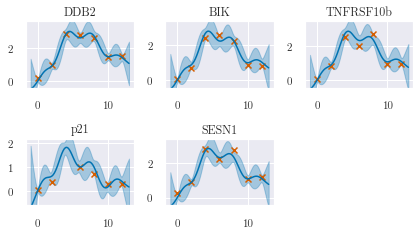

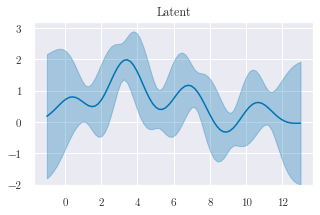

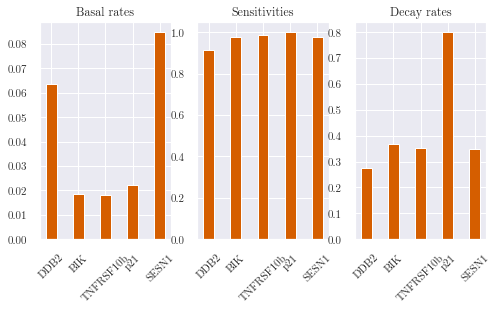

In [8]:

t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

plotter.plot_outputs(t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)

plotter.plot_latents(t_predict, ylim=(-2, 3.2), num_samples=0)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
constraints = dict(model.named_constraints())
for key in ['mean_module.raw_basal', 'covar_module.raw_sensitivity', 'covar_module.raw_decay']:
    val = trainer.parameter_trace[key][-1].squeeze()
    if key + '_constraint' in constraints:
        val = constraints[key + '_constraint'].transform(val)
    kinetics.append(val.numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.9872e-01,  4.1641e-01,  5.5389e-01,  ...,  6.7658e-04,
          5.5656e-04,  4.2953e-04],
        [ 1.6957e-02,  2.1970e-02,  2.6526e-02,  ...,  1.5813e-03,
          1.3037e-03,  1.0082e-03],
        ...,
        [-2.9145e-03, -3.9802e-03, -5.1638e-03,  ...,  9.2491e-03,
          7.6174e-03,  5.8898e-03],
        [-3.9440e-03, -5.3437e-03, -6.8621e-03,  ...,  4.2490e-02,
          3.5119e-02,  2.7175e-02],
        [-2.0626e-03, -2.7988e-03, -3.6009e-03,  ..., -6.6387e-02,
         -5.7068e-02, -4.5466e-02]], dtype=torch.float64,
       grad_fn=<CholeskySolveBackward>)
tensor(0.9290, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0720, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor([[ 2.0524e-02,  2.9205e-02,  3.9819e-02,  ..., -3.5730e-05,
         -2.9224e-05, -2.2455e-05],
        [ 2.9205e-02,  4.1583e-02,  5.6738e-02,  ..., -4.8739e-05,
         -3.9817e

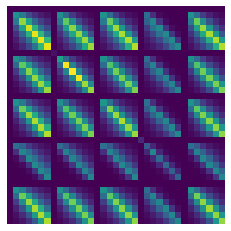

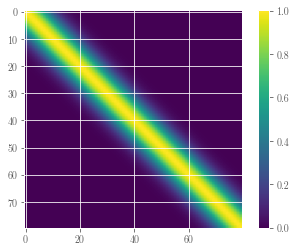

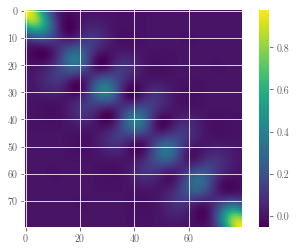

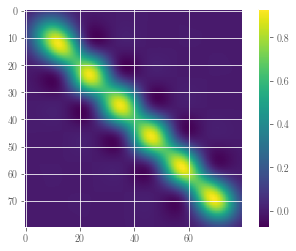

In [6]:
from matplotlib import pyplot as plt

Kxx = model.covar_module(model.train_t, model.train_t).evaluate()

plt.figure()
plt.imshow(Kxx.detach())
plt.axis('off')

Kxf = model.covar_module.K_xf(model.train_t, t_predict).type(torch.float64)

Kfx = torch.transpose(Kxf, 0, 1)
L = torch.cholesky(Kxx)

KxxKxf = torch.cholesky_solve(Kxf, L, upper=False)

# K_inv = torch.inverse(Kxx)

print(KxxKxf)
# KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
# print(KfxKxx)
# mu = torch.matmul(KfxKxx, model.train_y).view(-1)
# plt.figure()
# plt.plot(mu.detach())

Kff = model.covar_module.K_ff(t_predict, t_predict)  # (100, 500)
plt.figure()
plt.imshow(Kff.detach())
plt.colorbar()
var = Kff - torch.matmul(Kfx, KxxKxf)
print(torch.diagonal(torch.matmul(Kfx, KxxKxf)).max())
print(torch.diagonal(var).min())
plt.figure()
plt.imshow(var.detach())
plt.colorbar()

plt.figure()
kfxf = torch.matmul(Kfx, KxxKxf)
print(kfxf)
plt.imshow(kfxf.detach())
plt.colorbar()

